In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import matplotlib.dates as mdates

with open("../data/sample_rich_schema.json", "r") as f:
    schema = json.load(f)

fields = list(schema["columns"].keys())
print("Available fields:", fields)
overleaf_dir = "/Users/guanlil1/Dropbox/应用/Overleaf/DataWorkloadGen/figures/"

fontsize_title=30
fontsize_legend=20
fontsize_ticks=26

Available fields: ['id', 'name', 'age', 'income', 'is_active', 'signup_date', 'category', 'comment']


In [2]:

def print_column_info(column_name):
    # column_name = "income"  # Change this to any field you want to explore
    col_info = schema["columns"][column_name]
    
    print(f"Field: {column_name}")
    print(f"Unique values: {col_info['num_unique']}")
    print(f"Value range: {col_info.get('range', {})}")
    print(f"CDF: {col_info.get('cdf', {})}")

for field in fields:
    print_column_info(field)

Field: id
Unique values: 10
Value range: {'min': 1, 'max': 10}
CDF: {'0%': 1.0, '25%': 3.25, '50%': 5.5, '75%': 7.75, '100%': 10.0}
Field: name
Unique values: 10
Value range: {}
CDF: {}
Field: age
Unique values: 8
Value range: {'min': 25, 'max': 58}
CDF: {'0%': 25.0, '25%': 31.0, '50%': 46.0, '75%': 50.0, '100%': 58.0}
Field: income
Unique values: 10
Value range: {'min': 38076.51, 'max': 113386.45}
CDF: {'0%': 38076.51, '25%': 43600.5775, '50%': 47772.715, '75%': 83549.13750000001, '100%': 113386.45}
Field: is_active
Unique values: 2
Value range: {}
CDF: {}
Field: signup_date
Unique values: 10
Value range: {}
CDF: {}
Field: category
Unique values: 3
Value range: {}
CDF: {}
Field: comment
Unique values: 3
Value range: {}
CDF: {}


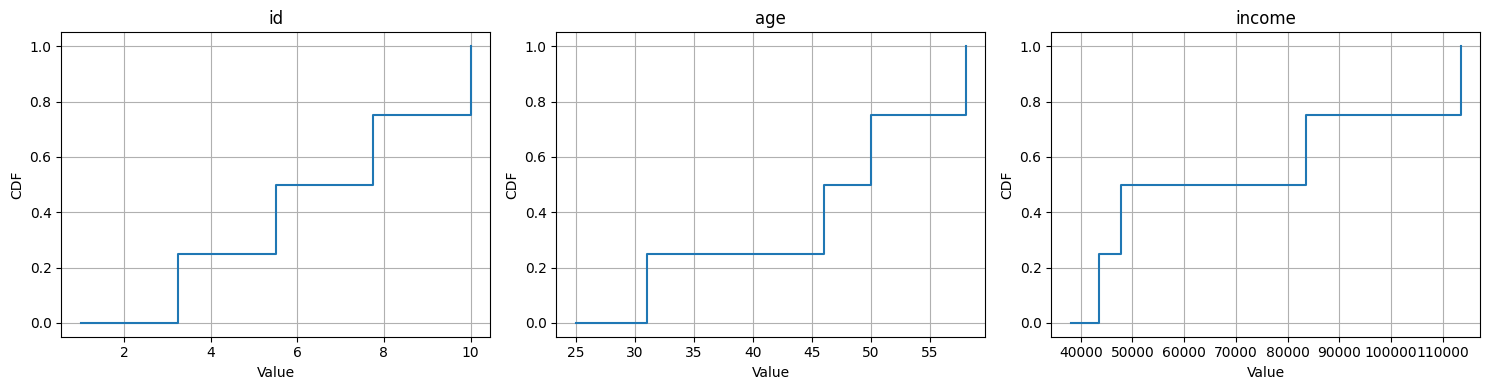

In [3]:
import matplotlib.pyplot as plt
import math

def plot_all_cdfs_subplots(schema, max_cols=3, figsize_per_subplot=(5, 4)):
    cdf_columns = [col for col, info in schema["columns"].items() if "cdf" in info]
    num_cols = min(max_cols, len(cdf_columns))
    num_rows = math.ceil(len(cdf_columns) / num_cols)

    figsize = (figsize_per_subplot[0] * num_cols, figsize_per_subplot[1] * num_rows)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(cdf_columns):
        info = schema["columns"][col]
        quantiles = sorted((int(k.strip('%')), v) for k, v in info["cdf"].items())
        x = [q[1] for q in quantiles]
        y = [q[0] / 100.0 for q in quantiles]

        ax = axes[i]
        ax.step(x, y, where='post')
        ax.set_title(col)
        ax.set_xlabel("Value")
        ax.set_ylabel("CDF")
        ax.grid(True)

    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Run it
plot_all_cdfs_subplots(schema)


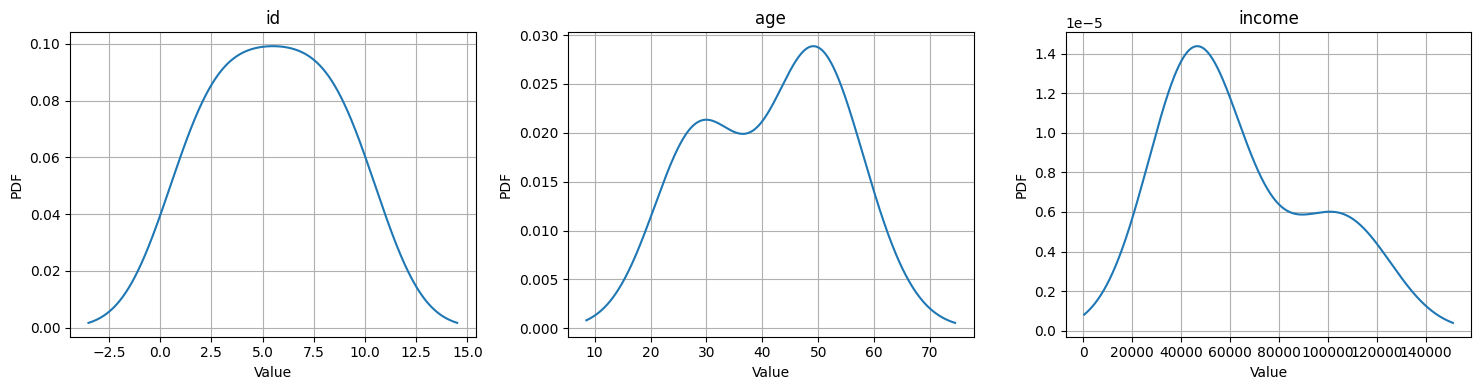

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_all_pdfs_from_csv(csv_path, schema, max_cols=3, figsize_per_subplot=(5, 4)):
    df = pd.read_csv(csv_path)
    pdf_columns = [col for col, info in schema["columns"].items() if str(df[col].dtype) in ["int64", "float64"]]
    
    num_cols = min(max_cols, len(pdf_columns))
    num_rows = math.ceil(len(pdf_columns) / num_cols)
    figsize = (figsize_per_subplot[0] * num_cols, figsize_per_subplot[1] * num_rows)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(pdf_columns):
        ax = axes[i]
        df[col].dropna().plot(kind='density', ax=ax)
        ax.set_title(col)
        ax.set_xlabel("Value")
        ax.set_ylabel("PDF")
        ax.grid(True)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage
plot_all_pdfs_from_csv("../data/sample_rich.csv", schema)


In [5]:


output_dir = "predicate_distribution"
os.makedirs(output_dir, exist_ok=True)

def plot_predicate_distribution(csv_path, column="age", bins=20, kind="hist", file_name=""):
    df = pd.read_csv(csv_path)
    centers = []

    for _, row in df.iterrows():
        sql = row["sql"]
        match = re.search(rf"{column} BETWEEN ([\d\.]+) AND ([\d\.]+)", sql)
        if match:
            v1 = float(match.group(1))
            v2 = float(match.group(2))
            center = (v1 + v2) / 2
            centers.append(center)

    plt.figure(figsize=(8, 4))
    if kind == "hist":
        plt.hist(centers, bins=bins, alpha=0.7, color="skyblue", edgecolor="black")
    elif kind == "kde":
        import seaborn as sns
        sns.kdeplot(centers, fill=True)

    plt.title(f"Distribution of Predicate Center for `{column}`")
    plt.xlabel(f"{column} (center of BETWEEN)")
    plt.ylabel("Frequency" if kind == "hist" else "Density")
    plt.grid(True)
    plt.tight_layout()
    
    plt.savefig(os.path.join(output_dir, f"{file_name}.png"), format='png', bbox_inches='tight')
    plt.savefig(os.path.join(overleaf_dir, f"{file_name}.pdf"), format='pdf', bbox_inches='tight')
    plt.show()


In [6]:
def plot_predicate_over_time(csv_path, column="age", file_name=""):
    df = pd.read_csv(csv_path)
    times, values = [], []

    for _, row in df.iterrows():
        ts = pd.to_datetime(row["timestamp"])
        sql = row["sql"]

        # 提取谓词值
        match = re.search(rf"{column} BETWEEN ([\d\.]+) AND ([\d\.]+)", sql)
        if match:
            v1 = float(match.group(1))
            v2 = float(match.group(2))
            center = (v1 + v2) / 2
            times.append(ts)
            values.append(center)

    plt.figure(figsize=(10, 5))
    plt.plot(times, values, marker="o", linestyle="-", alpha=0.7)
    plt.title(f"Predicate Center for `{column}` Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel(f"{column} (center of BETWEEN)")
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f"{file_name}.png"), format='png', bbox_inches='tight')
    plt.savefig(os.path.join(overleaf_dir, f"{file_name}.pdf"), format='pdf', bbox_inches='tight')
    plt.show()


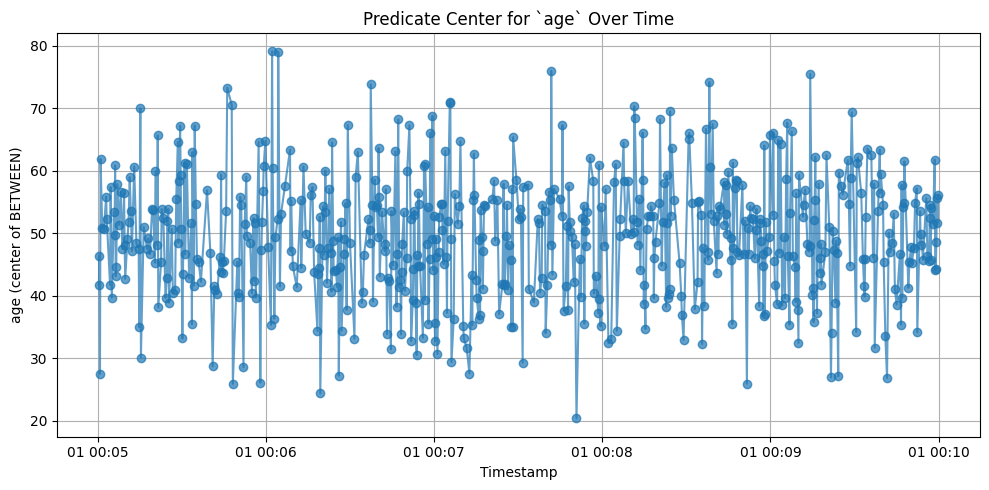

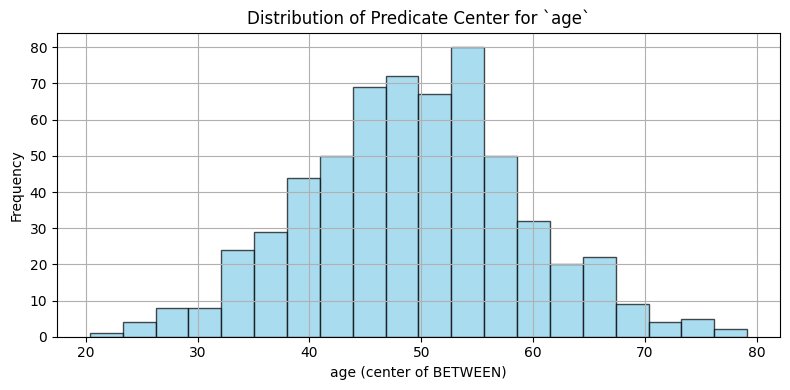

In [7]:
plot_predicate_over_time("../data/generated_queries_age_normal_50.csv", column="age", file_name="queries_age_normal_50_over_time")
plot_predicate_distribution("../data/generated_queries_age_normal_50.csv", column="age", file_name="queries_age_normal_50_distribution")

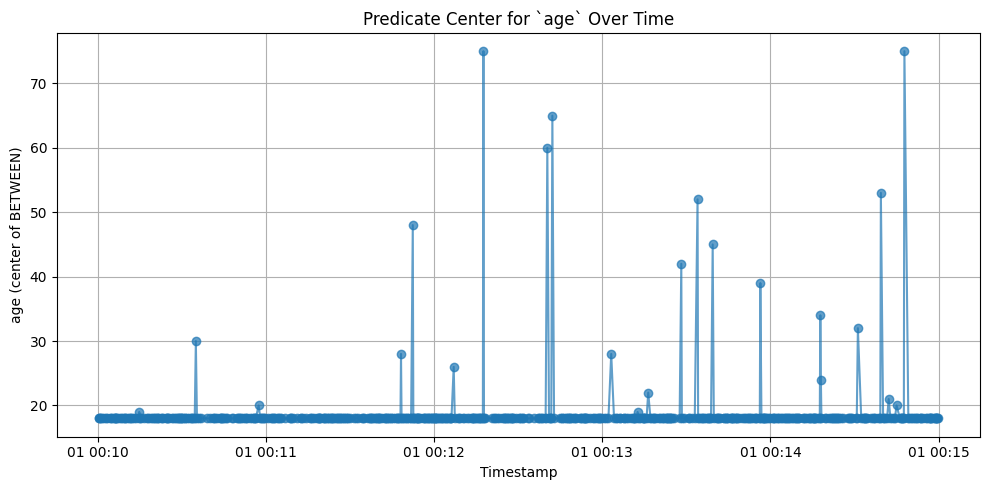

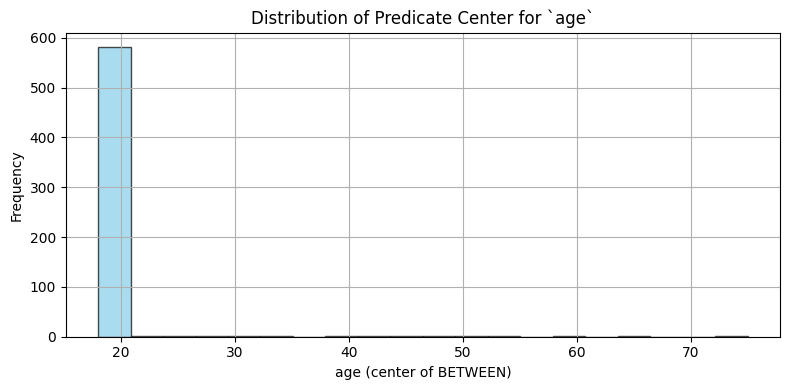

In [8]:
plot_predicate_over_time("../data/generated_queries_age_zipf_50.csv", column="age", file_name="generated_queries_age_zipf_50_over_time")
plot_predicate_distribution("../data/generated_queries_age_zipf_50.csv", column="age", file_name="generated_queries_age_zipf_50_distribution")

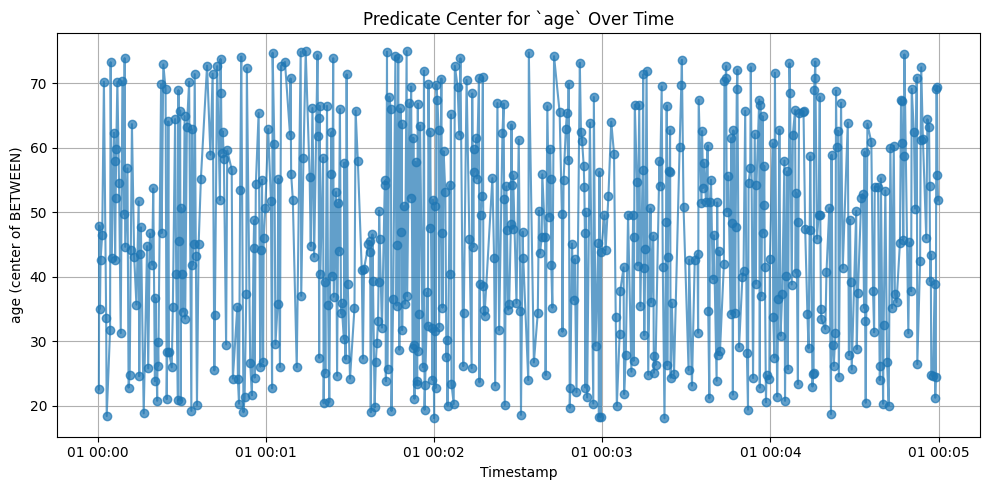

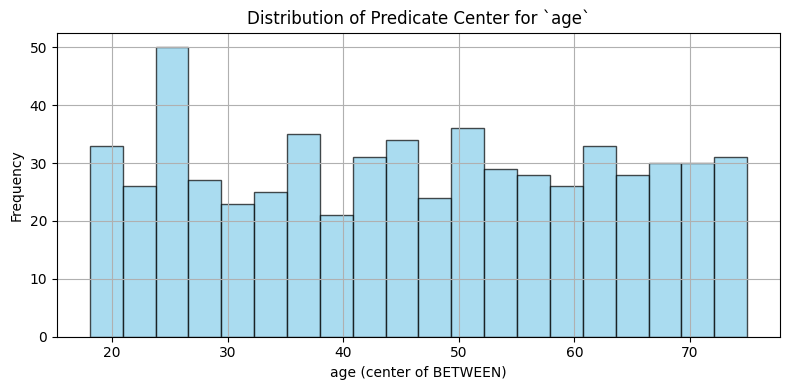

In [9]:
plot_predicate_over_time("../data/generated_queries_age_uniform.csv", column="age", file_name="generated_queries_age_uniform_over_time")
plot_predicate_distribution("../data/generated_queries_age_uniform.csv", column="age", file_name="generated_queries_age_uniform_distribution")

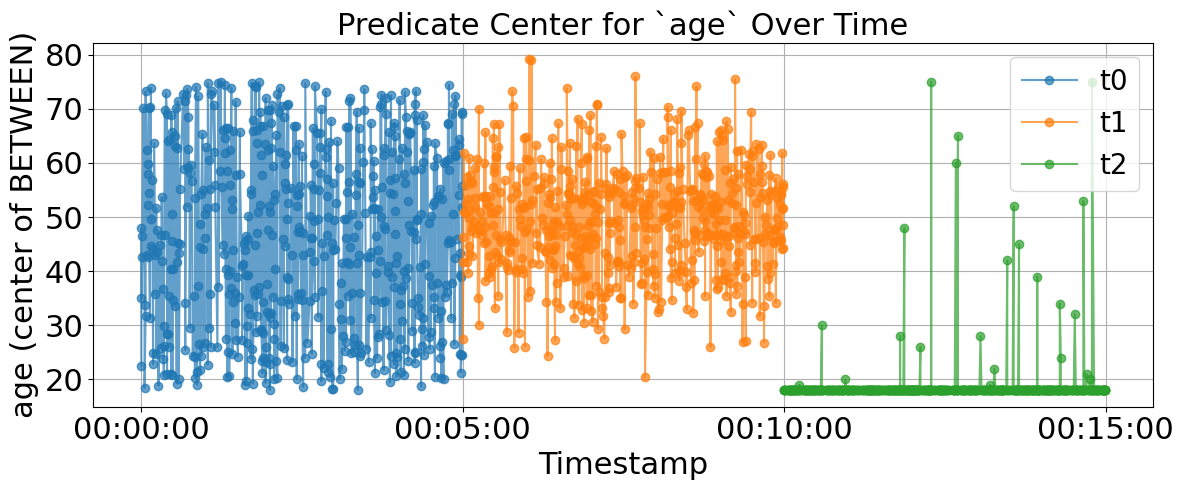

In [10]:
# def plot_predicate_over_time_multi(csv_paths, column="age", labels=None, colors=None):
#     plt.figure(figsize=(12, 5))
#     split_times = []
#     current_time_offset = 0

#     for idx, csv_path in enumerate(csv_paths):
#         df = pd.read_csv(csv_path)
#         times, values = [], []

#         for _, row in df.iterrows():
#             ts = pd.to_datetime(row["timestamp"])
#             sql = row["sql"]

#             match = re.search(rf"{column} BETWEEN ([\\d\\.]+) AND ([\\d\\.]+)", sql)
#             if match:
#                 v1 = float(match.group(1))
#                 v2 = float(match.group(2))
#                 center = (v1 + v2) / 2
#                 times.append(current_time_offset)
#                 values.append(center)
#                 current_time_offset += 1

#         label = labels[idx] if labels else f"Series {idx}"
#         color = colors[idx] if colors else None
#         plt.plot(times, values, marker="o", linestyle="-", alpha=0.7, label=label, color=color)
#         split_times.append(current_time_offset - 0.5)

#     # for st in split_times[:-1]:
#     #     plt.axvline(x=st, color="gray", linestyle="--", linewidth=1)

#     plt.title(f"Predicate Center for `{column}` Across Batches")
#     plt.xlabel("Query Index")
#     plt.ylabel(f"{column} (center of BETWEEN)")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

output_dir = "case_study"
os.makedirs(output_dir, exist_ok=True)


fontsize_title=22
fontsize_legend=20
fontsize_ticks=22

def plot_predicate_over_time_multi(csv_paths, column="age", labels=None, colors=None, file_name=""):
    plt.figure(figsize=(12, 5))

    for idx, csv_path in enumerate(csv_paths):
        df = pd.read_csv(csv_path)
        times, values = [], []
    
        for _, row in df.iterrows():
            ts = pd.to_datetime(row["timestamp"]).floor("s")
            # timestamps = pd.to_datetime(df["timestamp"]).dt.floor("s")
            sql = row["sql"]
    
            # 提取谓词值
            match = re.search(rf"{column} BETWEEN ([\d\.]+) AND ([\d\.]+)", sql)
            if match:
                v1 = float(match.group(1))
                v2 = float(match.group(2))
                center = (v1 + v2) / 2
                times.append(ts)
                values.append(center)

        plt.plot(times, values, marker="o", linestyle="-", label=labels[idx], alpha=0.7)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    plt.title(f"Predicate Center for `{column}` Over Time", fontsize=fontsize_title)
    plt.xticks(fontsize=fontsize_ticks)
    plt.yticks(fontsize=fontsize_ticks)
    plt.xlabel("Timestamp", fontsize=fontsize_title)
    plt.ylabel(f"{column} (center of BETWEEN)", fontsize=fontsize_title)
    plt.grid(True)
    plt.legend(fontsize=fontsize_legend)
    plt.tight_layout()
    if file_name:
        plt.savefig(os.path.join(output_dir, f"{file_name}.png"), format='png', bbox_inches='tight')
        plt.savefig(os.path.join(overleaf_dir, f"{file_name}.pdf"), format='pdf', bbox_inches='tight')
    plt.show()

plot_predicate_over_time_multi(
    ["../data/generated_queries_age_uniform.csv", "../data/generated_queries_age_normal_50.csv", "../data/generated_queries_age_zipf_50.csv"],
    # ["../data/generated_queries_age_uniform.csv"],
    column="age",
    labels=["t0", "t1", "t2"],
    colors=["blue", "green", "red"],
    file_name="case_study_predicate_center"
)

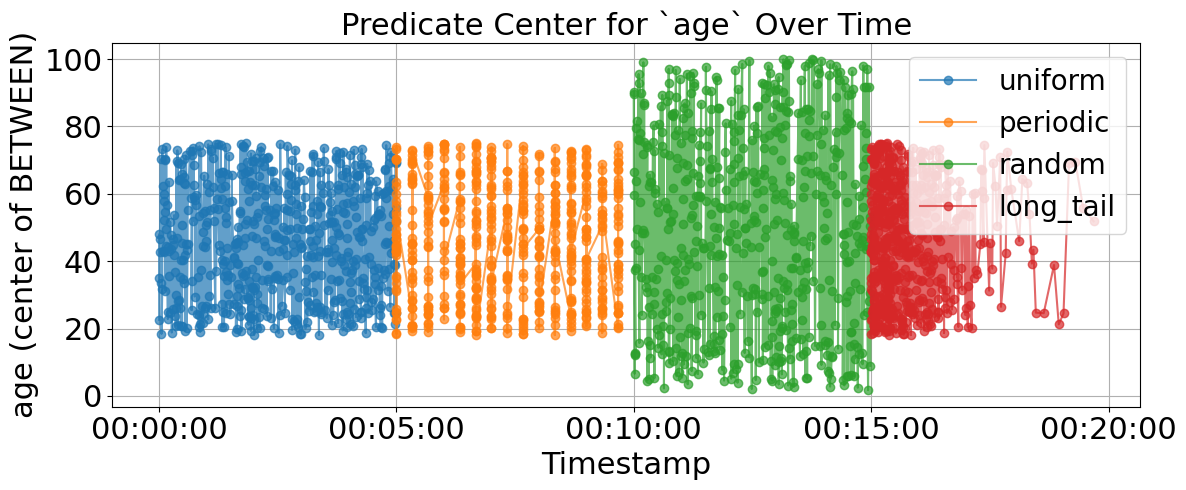

In [11]:
plot_predicate_over_time_multi(
    ["../data/generated_queries_age_uniform.csv", "../data/generated_queries_age_uniform_periodic.csv",
     "../data/generated_queries_age_uniform_random.csv", "../data/generated_queries_age_uniform_long_tail.csv"],
    column="age",
    labels=["uniform", "periodic", "random", "long_tail"],
    colors=["blue", "green", "red"],
    # file_name="case_study_frequency"
)

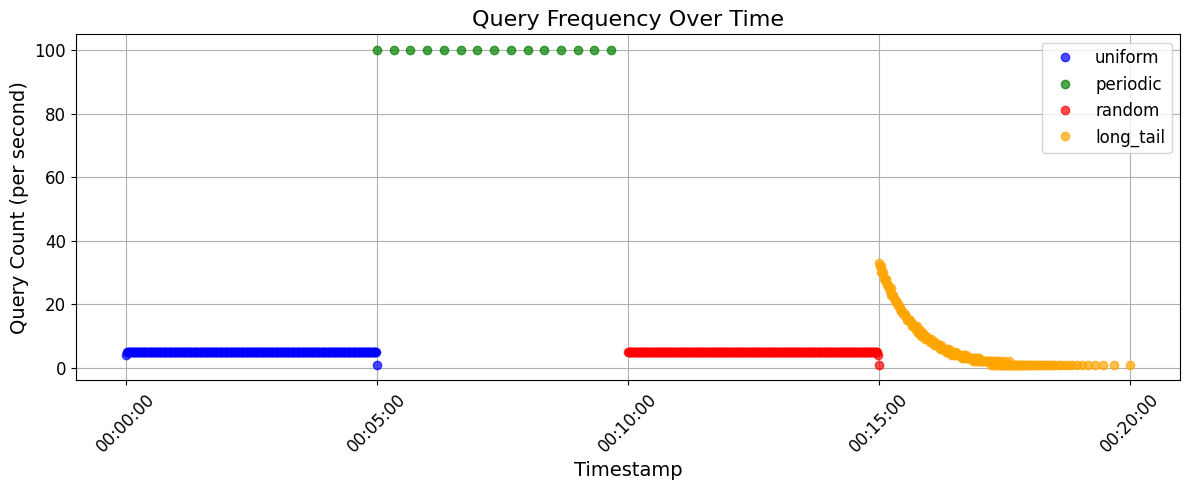

In [12]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from collections import Counter
# import os


# def plot_query_frequency_over_time(csv_paths, labels=None, colors=None, file_name=""):
#     plt.figure(figsize=(12, 5))

#     for idx, csv_path in enumerate(csv_paths):
#         df = pd.read_csv(csv_path)
#         timestamps = pd.to_datetime(df["timestamp"])

#         second_bins = timestamps.dt.strftime("%H:%M:%S")
#         counter = Counter(second_bins)
#         times_sorted = sorted(counter.keys())
#         counts = [counter[t] for t in times_sorted]

#         label = labels[idx] if labels else f"Series {idx}"
#         color = colors[idx] if colors else None

#         # print(counts)
#         # print(times_sorted)

#         plt.plot(times_sorted, counts, marker="o", linestyle=None, alpha=0.7, label=label, color=color)

#     plt.title("Query Count per Second", fontsize=fontsize_title)
#     # plt.xticks(rotation=45, fontsize=fontsize_ticks)
#     plt.yticks(fontsize=fontsize_ticks)

#     plt.xticks([])
#     # plt.yticks([])
    
#     plt.xlabel("Time (HH:MM:SS)", fontsize=fontsize_title)
#     plt.ylabel("Query Count", fontsize=fontsize_title)
#     plt.grid(True)
#     plt.legend(fontsize=fontsize_legend)
#     plt.tight_layout()

#     plt.savefig(os.path.join(output_dir, f"{file_name}.png"), format='png', bbox_inches='tight')
#     plt.savefig(os.path.join(overleaf_dir, f"{file_name}.pdf"), format='pdf', bbox_inches='tight')
#     plt.show()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from collections import Counter
import os

def plot_query_frequency_over_time(csv_paths, labels=None, colors=None, file_name="query_freq"):
    plt.figure(figsize=(12, 5))

    for idx, csv_path in enumerate(csv_paths):
        df = pd.read_csv(csv_path)
        timestamps = pd.to_datetime(df["timestamp"])

        # Round to nearest second (floor)
        timestamps_rounded = timestamps.dt.floor("s")
        counter = Counter(timestamps_rounded)
        times_sorted = sorted(counter.keys())
        counts = [counter[t] for t in times_sorted]

        label = labels[idx] if labels else f"Series {idx}"
        color = colors[idx] if colors else None

        # Plot only markers (no line)
        plt.plot(times_sorted, counts, marker="o", linestyle="None", alpha=0.7, label=label, color=color)

    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    plt.title("Query Frequency Over Time", fontsize=16)
    plt.xlabel("Timestamp", fontsize=14)
    plt.ylabel("Query Count (per second)", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # Save to file if directory variables exist
    if file_name:
        if "output_dir" in globals() and "overleaf_dir" in globals():
            plt.savefig(os.path.join(output_dir, f"{file_name}.png"), format='png', bbox_inches='tight')
            plt.savefig(os.path.join(overleaf_dir, f"{file_name}.pdf"), format='pdf', bbox_inches='tight')

    plt.show()


plot_query_frequency_over_time(
    ["../data/generated_queries_age_uniform.csv", "../data/generated_queries_age_uniform_periodic.csv",
     "../data/generated_queries_age_uniform_random.csv", "../data/generated_queries_age_uniform_long_tail.csv"],
    labels=["uniform", "periodic", "random", "long_tail"],
    colors=["blue", "green", "red", "orange"],
    file_name="case_study_frequency"
)

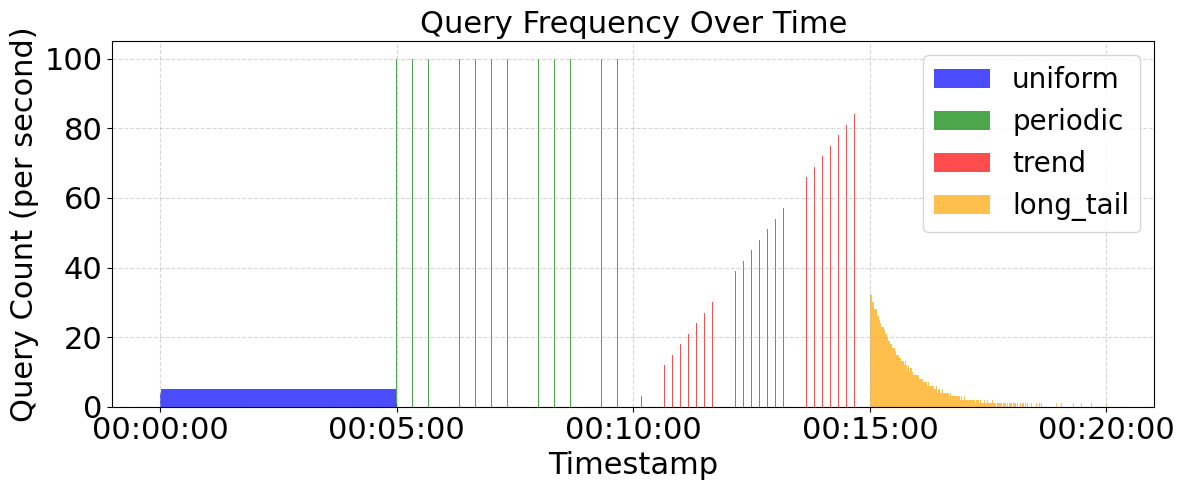

In [14]:
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter


def plot_query_frequency_histogram(csv_paths, labels=None, colors=None, file_name="query_histogram"):
    plt.figure(figsize=(12, 5))
    width = pd.Timedelta(seconds=1)  # 每根柱子的宽度

    for idx, csv_path in enumerate(csv_paths):
        df = pd.read_csv(csv_path)
        timestamps = pd.to_datetime(df["timestamp"]).dt.floor("s")  # 按秒计数
        counter = Counter(timestamps)

        times = sorted(counter.keys())
        counts = [counter[t] for t in times]
        color = colors[idx] if colors else None
        label = labels[idx] if labels else f"Series {idx}"

        # if idx == 1:
        #     print(times)
        #     print(counts)
        #     width = pd.Timedelta(seconds=2)
        # else:
        #     width = pd.Timedelta(seconds=1)
        
        plt.bar(times, counts, width=width, align="center", color=color, alpha=0.7, label=label)

    # 时间轴美化
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    plt.xticks(fontsize=fontsize_ticks)
    plt.yticks(fontsize=fontsize_ticks)
    # plt.xticks([])
    plt.xlabel("Timestamp", fontsize=fontsize_title)
    plt.ylabel("Query Count (per second)", fontsize=fontsize_title)
    plt.title("Query Frequency Over Time", fontsize=fontsize_title)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(fontsize=fontsize_legend)
    plt.tight_layout()

    if "output_dir" in globals() and "overleaf_dir" in globals():
        plt.savefig(os.path.join(output_dir, f"{file_name}.png"), format='png', bbox_inches='tight')
        plt.savefig(os.path.join(overleaf_dir, f"{file_name}.pdf"), format='pdf', bbox_inches='tight')

    plt.show()


plot_query_frequency_histogram(
    ["../data/generated_queries_age_uniform.csv", "../data/generated_queries_age_uniform_periodic.csv",
     "../data/generated_queries_age_uniform_trend.csv", "../data/generated_queries_age_uniform_long_tail.csv"],
    labels=["uniform", "periodic", "trend", "long_tail"],
    colors=["blue", "green", "red", "orange"],
    file_name="case_study_frequency"
)

SELECT sample_rich.age, sample_rich.signup_date, sample_rich.category FROM sample_rich WHERE sample_rich.name LIKE 'sample' AND sample_rich.age BETWEEN 19.92 AND 25.2 ORDER BY sample_rich.signup_date LIMIT 100;
SELECT sample_rich.age, sample_rich.signup_date, sample_rich.category FROM sample_rich WHERE sample_rich.name LIKE 'sample' AND sample_rich.age BETWEEN 45.29 AND 50.57 ORDER BY sample_rich.signup_date LIMIT 100;
SELECT sample_rich.age, sample_rich.signup_date, sample_rich.category FROM sample_rich WHERE sample_rich.name LIKE 'sample' AND sample_rich.age BETWEEN 32.42 AND 37.7 ORDER BY sample_rich.signup_date LIMIT 100;
SELECT sample_rich.age, sample_rich.signup_date, sample_rich.category FROM sample_rich WHERE sample_rich.name LIKE 'sample' AND sample_rich.age BETWEEN 39.95 AND 45.23 ORDER BY sample_rich.signup_date LIMIT 100;
SELECT sample_rich.income, sample_rich.category, sample_rich.name FROM sample_rich WHERE sample_rich.category = 'A' AND sample_rich.age BETWEEN 43.735 AND

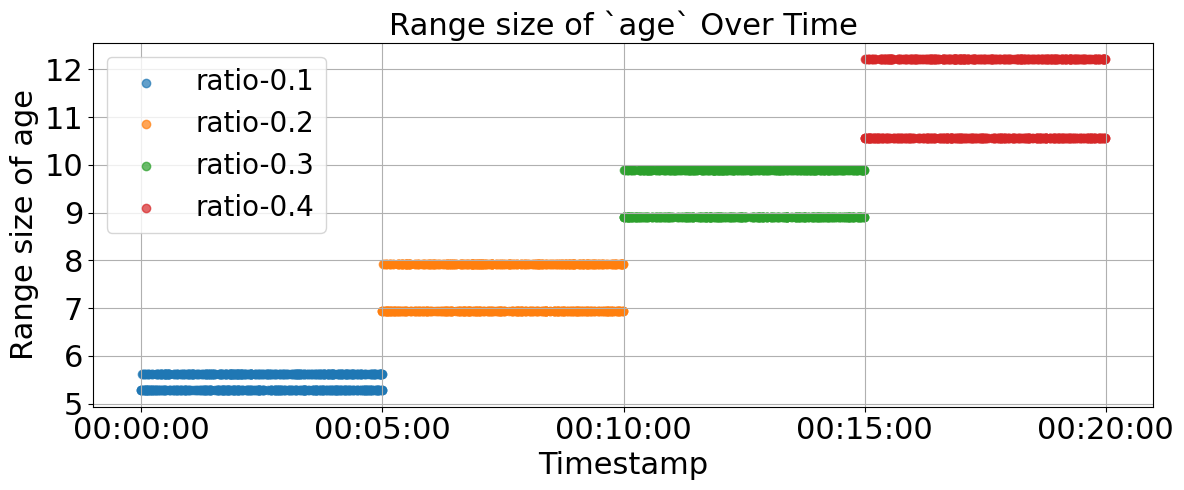

In [66]:
def plot_predicate_over_time_multi(csv_paths, column="age", labels=None, colors=None, file_name=""):
    plt.figure(figsize=(12, 5))

    for idx, csv_path in enumerate(csv_paths):
        df = pd.read_csv(csv_path)
        times, values = [], []
    
        for _, row in df.iterrows():
            ts = pd.to_datetime(row["timestamp"]).floor("s")
            # timestamps = pd.to_datetime(df["timestamp"]).dt.floor("s")
            sql = row["sql"]
    
            # 提取谓词值
            match = re.search(rf"{column} BETWEEN ([\d\.]+) AND ([\d\.]+)", sql)
            if match:
                print(sql)
                v1 = float(match.group(1))
                v2 = float(match.group(2))
                range_size = (v2 - v1)
                times.append(ts)
                values.append(range_size)
                # print(v1, v2, range_size)

        # plt.plot(times, values, marker="o", linestyle="-", label=labels[idx], alpha=0.7)
        plt.scatter(times, values, marker="o", label=labels[idx], alpha=0.7)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    plt.title(f"Range size of `{column}` Over Time", fontsize=fontsize_title)
    plt.xticks(fontsize=fontsize_ticks)
    plt.yticks(fontsize=fontsize_ticks)
    plt.xlabel("Timestamp", fontsize=fontsize_title)
    plt.ylabel(f"Range size of {column}", fontsize=fontsize_title)
    plt.grid(True)
    plt.legend(fontsize=fontsize_legend)
    plt.tight_layout()
    if file_name:
        plt.savefig(os.path.join(output_dir, f"{file_name}.png"), format='png', bbox_inches='tight')
        plt.savefig(os.path.join(overleaf_dir, f"{file_name}.pdf"), format='pdf', bbox_inches='tight')
    plt.show()

plot_predicate_over_time_multi(
    ["../data/generated_queries_age_uniform.csv", "../data/generated_queries_age_uniform_selectivity_2.csv", 
     "../data/generated_queries_age_uniform_selectivity_3.csv", "../data/generated_queries_age_uniform_selectivity_4.csv"],
    # ["../data/generated_queries_age_uniform.csv"],
    column="age",
    labels=["ratio-0.1", "ratio-0.2", "ratio-0.3", "ratio-0.4"],
    colors=["blue", "green", "red", "orange"],
    file_name="case_study_predicate_range_size"
)

/Users/guanlil1/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


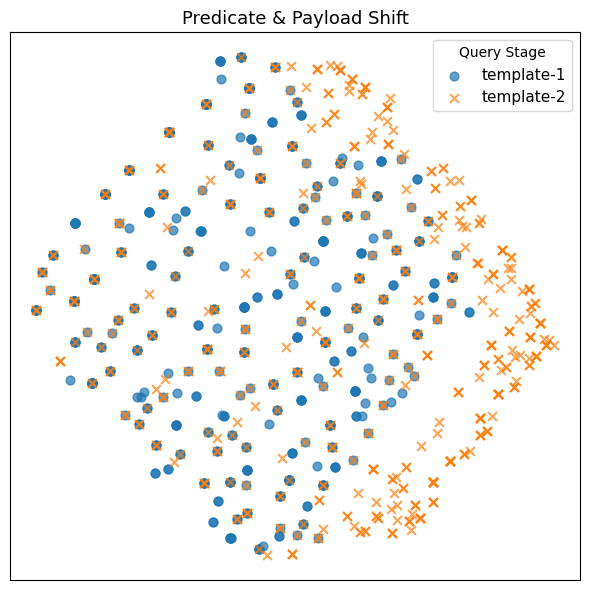

In [63]:

type_arr = ["numeric", "string", "datetime", "categorical"]
def sql_to_feature_vector(template):
    num_predicates = len(template.get("predicate", []))
    num_payload = len(template.get("payload", {}).get("columns", []))
    # has_agg = int(template.get("payload", {}).get("aggregation") is not None)
    # has_order_by = int(template.get("payload", {}).get("order_by") is not None)
    result = [num_predicates, num_payload]
    
    predicate_type_vector = [0] * 4
    type_arr = ["numeric", "string", "datetime", "categorical"]

    # print(template['predicate'])
    for predicate in template['predicate']:
        type_index = type_arr.index(predicate['type'])
        predicate_type_vector[type_index] += 1
        
    result.extend(predicate_type_vector)
    
    return result

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

# 画图函数
def plot_tsne(embedding, labels, title, save_name):
    embedding = np.array(embedding)
    tsne = TSNE(n_components=2, perplexity=50, n_iter=300, init="pca", learning_rate="auto", random_state=42)
    embedding_2d = tsne.fit_transform(embedding)

    stage_marker_map = {"template-1": "o", "template-2": "x", "t2": "D"}

    plt.figure(figsize=(6, 6))
    for stage in sorted(set(labels)):
        idx = [i for i, l in enumerate(labels) if l == stage]
        marker = stage_marker_map.get(stage, "o")
        plt.scatter(embedding_2d[idx, 0], embedding_2d[idx, 1],
                    label=stage, s=40, alpha=0.7, marker=marker)

    plt.legend(title="Query Stage", fontsize=11)
    plt.title(title, fontsize=13)
    plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    if save_name:
        plt.savefig(os.path.join(output_dir, save_name + ".png"), format="png", bbox_inches="tight")
        plt.savefig(os.path.join(overleaf_dir, save_name + ".pdf"), format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

def get_vector(template_files = ["../data/sample_templates.json"]):    
    vectors = []
    labels = []
    for i, template_file in enumerate(template_files):
        with open(template_file) as f:
            templates = json.load(f)
            for t in templates:
                vectors.append(sql_to_feature_vector(t))
                labels.append(f"template-{i+1}")

    return vectors, labels

vectors, labels = get_vector(["../data/sample_templates_predicates_2.json", "../data/sample_templates_predicates_3.json"])
# print(vectors, labels)

plot_tsne(vectors, labels, title="Predicate & Payload Shift", save_name="tsne_pred_payload")